In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
#from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/deep_fake_image_detection/Image_segregated/train'
valid_path = '/content/drive/MyDrive/deep_fake_image_detection/Image_segregated/val'

# add preprocessing layer to the front of VGG(include=False means donot add the last layer)
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)



58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
import os
import cv2
labels = ['fake', 'real']
img_size = 224
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
import os
import cv2
import numpy as np

def load_images_and_labels(folder_path):
    images = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)

            # Resize or preprocess the image as needed
            # img = cv2.resize(img, (width, height))

            label = int(filename.startswith("fake"))  # Assuming "fake" corresponds to label 0, adjust accordingly
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

# Example usage
train_folder = "/content/drive/MyDrive/Image_segregated_2/train"
X_train, y_train = load_images_and_labels(train_folder)

# Now you have X_train (images) and y_train (labels) ready to use


In [ ]:
X_train.shape

(1999, 224, 224, 3)

In [ ]:
y_train.shape

(1999,)

In [ ]:
# Example usage
val_folder = "/content/drive/MyDrive/Image_segregated_2/val"
X_val, y_val = load_images_and_labels(val_folder)


In [ ]:
X_val.shape

(800, 224, 224, 3)

In [ ]:
y_val.shape

(800,)

In [ ]:
test_folder = "/content/drive/MyDrive/Image_segregated_2/test"
X_test, y_test = load_images_and_labels(test_folder)


In [ ]:
X_test.shape

(809, 224, 224, 3)

In [ ]:
y_test.shape

(809,)

In [ ]:
# Normalize the data
X_train = np.array(X_train).astype('float32') / 255
X_val = np.array(X_val).astype('float32') / 255

In [ ]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
folders = glob('/content/drive/MyDrive/deep_fake_image_detection/Image_segregated/train')
len(folders)

0

In [ ]:
folders = glob('/content/drive/MyDrive/Image_segregated/train')


# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:

# useful for getting number of classes
folders = glob('/content/drive/MyDrive/Image_segregated/train/*')





from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Image_segregated/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Image_segregated/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')



Found 1999 images belonging to 2 classes.
Found 809 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-25-0aa33a0e172f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
63/63 [==============================] - 1661s 26s/step - loss: 0.7251 - accuracy: 0.5000 - val_loss: 0.7066 - val_accuracy: 0.5000
Epoch 2/10
63/63 [==============================] - 1653s 26s/step - loss: 0.7027 - accuracy: 0.5000 - val_loss: 0.7005 - val_accuracy: 0.5000
Epoch 3/10
63/63 [==============================] - 1587s 25s/step - loss: 0.7006 - accuracy: 0.5000 - val_loss: 0.6998 - val_accuracy: 0.5000
Epoch 4/10
63/63 [==============================] - 1638s 26s/step - loss: 0.6985 - accuracy: 0.5000 - val_loss: 0.6987 - val_accuracy: 0.5000
Epoch 5/10
63/63 [==============================] - 1630s 26s/step - loss: 0.6986 - accuracy: 0.5000 - val_loss: 0.7010 - val_accuracy: 0.5000
Epoch 6/10
63/63 [==============================] - 1631s 26s/step - loss: 0.7010 - accuracy: 0.5000 - val_loss: 0.7011 - val_accuracy: 0.5000
Epoch 7/10
63/63 [==============================] - 1636s 26s/step - loss: 0.7007 - accuracy: 0.5000 - val_loss: 0.7037 - val_accuracy: 0.5000

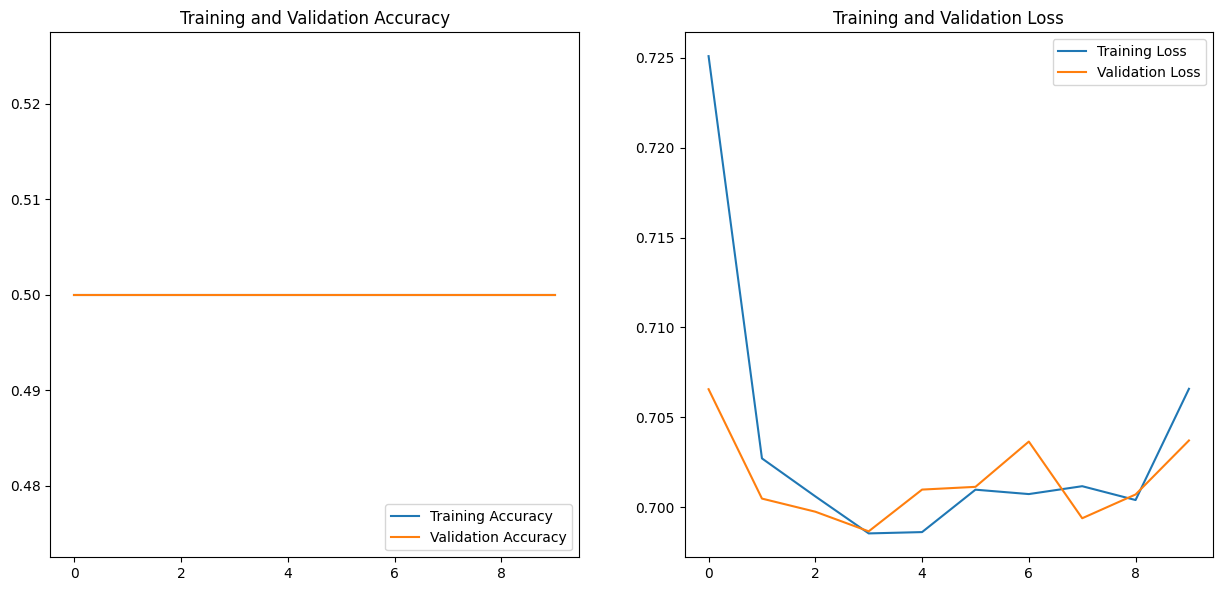

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import cv2
import numpy as np

# Load and preprocess the new image
img_path = '/content/drive/MyDrive/Image_segregated_2/test/Real1781.jpg'  # Update with the path to your new image


In [ ]:
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))  # Assuming the model was trained with input size (224, 224)
img = img / 255.0  # Normalize pixel values to be in the range [0, 1]
img = np.expand_dims(img, axis=0)  # Add batch dimension


In [ ]:
predictions = model.predict(img)


1/1 [==============================] - 2s 2s/step


In [ ]:
print(predictions)

[[0.39219183]]


In [ ]:
import os
import numpy as np
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model

# Load the pre-trained VGG16 model without the classification head
base_model = VGG16(weights='imagenet', include_top=False)

# Define a new model that outputs the output of the last convolutional layer
# This will be our context vector for the images
context_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)

def get_context_vectors_from_folder(folder_path, batch_size=32):
    image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
    return get_context_vectors(image_paths, batch_size)

def get_context_vectors(image_paths, batch_size=32):
    context_vectors = []
    num_batches = len(image_paths) // batch_size + 1

    for i in range(num_batches):
        batch_paths = image_paths[i*batch_size: (i+1)*batch_size]
        batch_images = []

        for image_path in batch_paths:
            img = image.load_img(image_path, target_size=(224, 224))
            x = image.img_to_array(img)
            x = preprocess_input(x)
            batch_images.append(x)

        batch_images = np.array(batch_images)

        # Get the context vectors for the batch of images
        batch_context_vectors = context_model.predict(batch_images)
        context_vectors.extend(batch_context_vectors)

    return np.array(context_vectors)




58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
# Example usage
folder_path = '/content/drive/MyDrive/Image_segregated/train/fake'
context_vectors = get_context_vectors_from_folder(folder_path)
print("Context vectors shape:", context_vectors.shape)

1/1 [==============================] - 4s 4s/step
Context vectors shape: (999, 14, 14, 512)


In [ ]:
context_vectors

array([[[[ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         ...,
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          10.268851 ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ]],

        [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
           0.       ,  0.       ],
         ...,
         [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          16.143593 ,  0.